# A/B Testing in PyMC: part II

<div class="alert alert-warning">
<h3>Goal of this session:</h3>

In this hands-on session, you will continue working with the synthetic dataset from yesterday. Your goal is to be able to perform Bayesian inference using the PyMC library. The insight gained from this session will help you understand:

- How to perform Bayesian A/B testing on data with Value conversions
- How to interpret the results

</div>


Let's practice what you have learned this morning. You will be using the [PyMC library](https://www.pymc.io/welcome.html) to Bayesian 
inference and explore posterior distributions. 

You only workout the case of two variants A and B with **Value conversions** using the data from yesterday. In the first part of this hands-on session, you compared A and B variants in terms of how many conversions they generate, and estimated the relative uplift of conversions between the two. Now you will be comparing A and B variants in terms of how much revenue they generate, and estimate the relative uplift of revenue between the two.

Below we put this setup into `PyMC` framework and find the posteriors. Let's start by importing the necessary libraries.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

## Your First Try

Remember the example with synthetic data where we had a website with two variants A and B. Let's assume that we have a Bernoulli likelihood for each variant, and we can model the conversion rate $\theta$ as Beta distribution for each variant. To start with, let's assume that we identical priors for both variants with $\alpha = 1$ and $\beta = 1$.

Note that according to our data, variant B's visitors are more likely to sign up: $$\theta_B \approx 51\% > \theta_A \approx 50\%$$

But their mean payment is smaller than variant A's visitors, because from data we observed that: 

$$\frac{1}{\lambda_B} \approx 55 < \frac{1}{\lambda_A} \approx 61$$

Remember that the expected revenue per visitor was $\frac{\theta}{\lambda}$. So, variant B has smaller expected revenue per visitor than variant A:

$$ 0.51 \times 55 <  0.50 \times 61$$

Therefore, the relative uplift should be negative: 

$$\mathrm{uplift} = \frac{\frac{\theta_B}{\lambda_B}}{\frac{\theta_A}{\lambda_A}} - 1 = \frac{0.51 \times 55}{0.50 \times 61} - 1 = -0.079$$


Let's assume that you have a weak prior for the mean payment amount, and the prior $\lambda$ is Gamma distributed with $\alpha = 1$ and $\beta = 1$. This will allow the data to have a stronger influence on the posterior, and make it easier for you to see how the mechanism works.

<div class="alert alert-success">

**Remarke on the notations**: we should be mindful that $\theta$ and $\lambda$ denote the true and unobserable parameters, and the observed values (e.g. conversion rate of 51\%) should be denoted differently, e.g. by $\hat{\theta}$. For simplicity we keep the same notation for both the true and observed values.

</div>

In [29]:
# as before we have variants A and B
variants  = ['A', 'B']

# let's define prior's parameters for the conversion rates
conv_alpha, conv_beta = [1, 1]

# let's define prior's parameters for the average payment 
payment_alpha, payment_beta = [1, 1]

Now, replace the `< >` with the correct values from the data:

In [3]:
# number of visitors for each variant 
visitors    = [1000, 1000]

# number of conversions (sign ups) for each variant
conversion = [502, 510]

# sum of payments for each variant
total_revenue = [30456, 28056]

In [ ]:
# number of visitors for each variant 
visitors    = [< >, < >]

# number of conversions (sign ups) for each variant
conversion = [< >, < >]

# sum of payments for each variant
total_revenue = [< >, < >]

The model, defined in the next cell, consist of four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior

In [30]:
with pm.Model() as example_model:

    #------------------------------------------------conversion rate model
    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = conv_alpha, 
                    beta  = conv_beta, 
                    shape = 2)
    
    # Likelihood of observations
    converted = pm.Binomial("converted", 
                            n        = visitors,      # total visitors
                            observed = conversion,     # total visitors converted
                            p        = theta,         # chance they convert
                            shape    = 2)  
    
    #------------------------------------------------revenue model
    # Priors for unknown model parameters
    lamda = pm.Gamma( "lamda", 
                    alpha = payment_alpha,
                    beta  = payment_beta,
                    shape = 2)
    
    # Likelihood of observations
    revenue = pm.Gamma("revenue", 
                        alpha    = conversion,            # total visitors converted
                        observed = total_revenue, 
                        beta     = lamda, 
                        shape    = 2)        
    
    # get the revenue per visitor
    revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta / lamda)

    #------------------------------------------------relative uplifts
    theta_uplift = pm.Deterministic(f"theta uplift", theta[1] / theta[0] - 1)
    lamda_uplift = pm.Deterministic(f"lamda uplift", (1 / lamda[1]) / (1 / lamda[0]) - 1)
    uplift       = pm.Deterministic(f"uplift", revenue_per_visitor[1] / revenue_per_visitor[0] - 1)

    #------------------------------------------------posterior
    # draw posterior samples
    trace = pm.sample(draws=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


In [5]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(1, 1),
 lamda ~ Gamma(1, f()),
 revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [6]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs  

[converted ~ Binomial(<constant>, theta),
 revenue ~ Gamma(<constant>, f(lamda))]

In [7]:
# Check the deterministic random variable:
example_model.deterministics

[revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [ ]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

In [9]:
# find out the shape of all trace.posterior variables
for var in trace.posterior:
    print(var, trace.posterior[var].shape)

theta (4, 5000, 2)
lamda (4, 5000, 2)
revenue_per_visitor (4, 5000, 2)
theta uplift (4, 5000)
lamda uplift (4, 5000)
uplift (4, 5000)


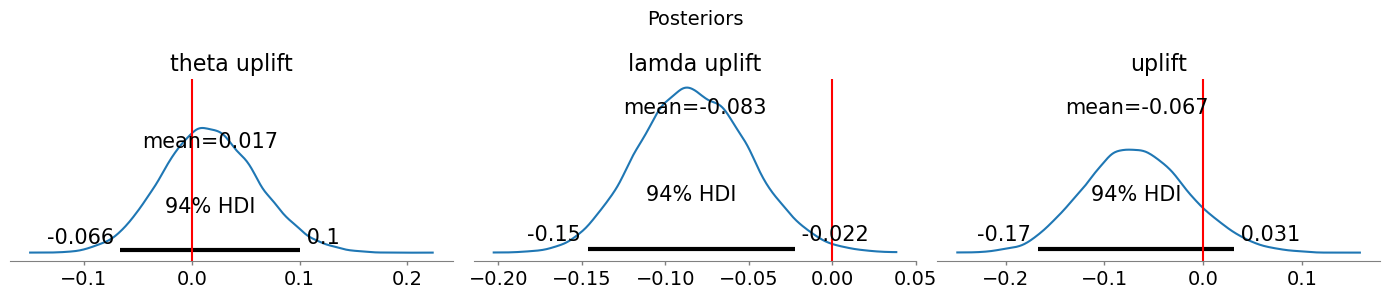

In [28]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i],)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

<div class="alert alert-info">
<h4>Task 1</h4>

Check out the range of value posterior distributions can take, especially the mean and the values covered by HDI. Then answer the following questions:

- What do you learn from the posterior distribution of uplift for $\theta$?

- What do you learn from the posterior distribution of uplift for $\lambda$?

- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI to include zero?
<br>
</div>



write your answer here

**Answer:**

1. The mean is positive indicating that B is slightly better than A in terms of conversion rate. We say slightly because the mass of the uplift distribution is around zero. 

2. For $\lambda$ the uplift is mostly negative, and zero is the upper bound of the HDI. This means that A is better than B in terms of revenue. That's no surprise because we know from data that the sum of payment for A was higher than B, and the prior played no role. 

3. The same argument is valid for $\frac{\theta}{\lambda}$ which is the revenue per visitor. A is overall doing better than B in terms of revenue per visitor.

Let's continue by exploring the posterior distributions.

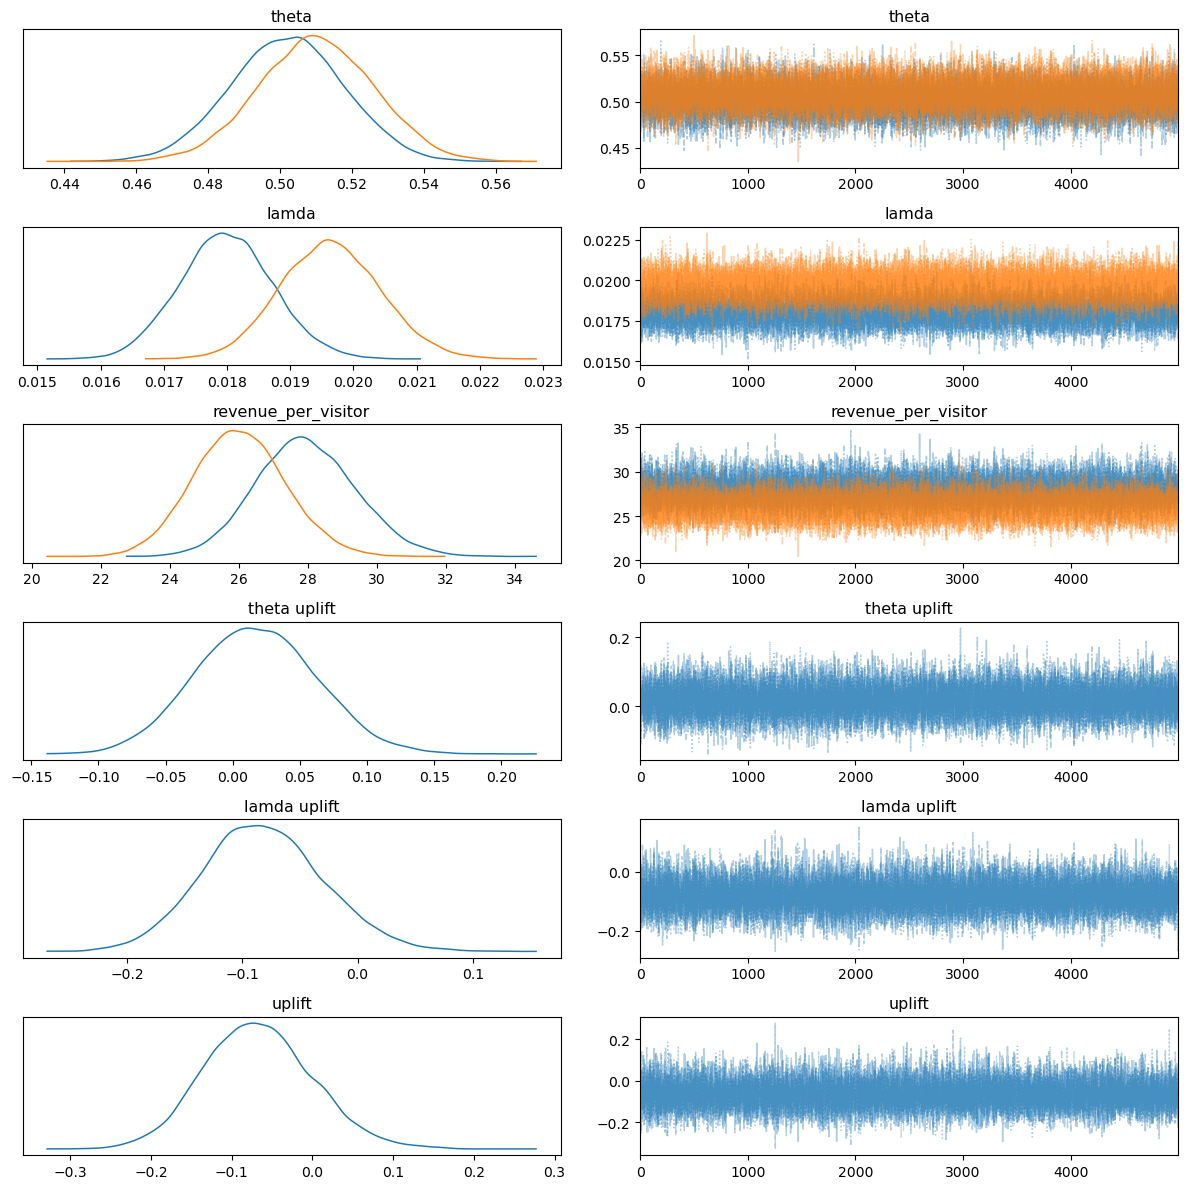

In [31]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

<div class="alert alert-info">
<h4>Task 2</h4>

Change the prior for $\lambda$ which is curently `Gamma(1,1)`.


- What do you learn from the posterior distribution of uplift for $\theta$?

- What do you learn from the posterior distribution of uplift for $\lambda$?

- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI to include zero?
<br>
</div>



write your answer here

**Answer:**

1. 

2. 

3. 